# _Flowing with JAX_

# Part 2: Real NVP

2020, [@glouppe](https://twitter.com/glouppe).

In this second notebook, we will use JAX to compose real NVP transformations (changes of variables parameterized by neural networks) into our very first normalizing flow.

# Preamble

In [1]:
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/home/glouppe/anaconda3/envs/jax"

import jax.numpy as np 
from jax import grad, jacfwd, jit, random, vmap
from jax.scipy.stats import multivariate_normal
rng = random.PRNGKey(0)

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as true_np

# Data

Our goal will be to learn a density estimator for the following synthetic 2D data $\mathbf{x}$:

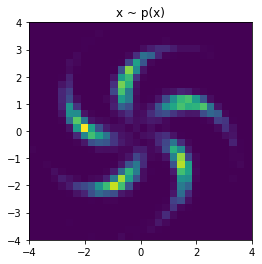

In [2]:
from toy_data import inf_train_gen
x = inf_train_gen(data="pinwheel", batch_size=10000)
D = x.shape[-1]
d = D // 2

plt.figure(figsize=(4, 4))
plt.hist2d(x[:, 0], x[:, 1], bins=30, range=[(-4, 4), (-4, 4)], density=True)
plt.title("x ~ p(x)")
plt.show()

# Real NVP

Introduced by Dinh et al (2016, [arXiv:1605.08803](https://arxiv.org/abs/1605.08803)), real-valued non-volume preserving (real NVP) transformations are defined as:

$$
\begin{align}
& \mathbf{z}_{1:d} = \mathbf{x}_{1:d}\\
& \mathbf{z}_{d+1:D} = \mathbf{x}_{d+1:D} \odot \exp(s(\mathbf{x}_{1:d})) + t(\mathbf{x}_{1:d})
\end{align}$$

In JAX, these can be implemented as follows, where `s` and `t` are neural network functions (as returned by `jax.experimental.stax.serial`) and `s_params` and `t_params` are their parameters:

In [3]:
def realnvp(x, s, s_params, t, t_params):
    x1, x2 = x[:d], x[d:]
    sx1 = s(s_params, x1)
    tx1 = t(t_params, x1)
    z1, z2 = x1, x2 * np.exp(sx1) + tx1
    z = np.concatenate([z1, z2], axis=-1)
    return z

def realnvp_inv(z, s, s_params, t, t_params): 
    z1, z2 = z[:d], z[d:]
    x1 = z1
    sx1 = s(s_params, x1)
    tx1 = t(t_params, x1)  
    x2 = (z2 - tx1) * np.exp(-sx1)
    x = np.concatenate([x1, x2], axis=-1)
    return x

As in Part 1, we will make use of JAX's API to vectorize the real NVP transformation and automatically derive its Jacobian, which we will then later plug into change of variables formula.

In [4]:
v_realnvp = vmap(realnvp, (0, None, None, None, None))
v_realnvp_inv = vmap(realnvp_inv, (0, None, None, None, None))
J_realnvp = jacfwd(realnvp)
v_J_realnvp = vmap(J_realnvp, (0, None, None, None, None))
vdet = vmap(np.linalg.det)

Note that because of the structure of the real NVP transformation, we could instead easily compute the Jacobian determinant as $\text{diag}(\exp(s(\mathbf{x}_{1:d})))$, which would be much more efficient. However, since we are dealing with 2D data, the computational overhead of generically using `jacfwd` and `np.linalg.det` is not really that much of an issue.

Now that we have defined a single transformation, our next step is to define a sequence $g$ of transformations as $g = g_N \circ g_{N-1} \circ \dots \circ g_1$. In our case, we will be chaining real NVP transformations into a normalizing flow:

In [5]:
from jax.experimental.stax import serial, Dense, Relu

def nf_init(n_steps):
    nf_nn, nf_params = [], []
    
    for i in range(n_steps):
        s_init, s = serial(Dense(1024), Relu, Dense(1024), Relu, Dense(1))
        _, s_params = s_init(rng, (d,))
        
        t_init, t = serial(Dense(1024), Relu, Dense(1024), Relu, Dense(1))
        _, t_params = t_init(rng, (d,))
    
        nf_nn.append((s, t))
        nf_params.append((s_params, t_params))
        
    return nf_nn, nf_params 

def nf_forward(x, nf_nn, nf_params, forward=v_realnvp, return_jacobians=False):
    z = x
    jacobians = []
    
    for i, ((s, t), (s_params, t_params)) in enumerate(zip(nf_nn, nf_params)):
        if i % 2 == 0:
            z = z[:, ::-1]
            
        if return_jacobians:
            J = v_J_realnvp(z, s, s_params, t, t_params)
            jacobians.append(J)
        
        z = forward(z, s, s_params, t, t_params)
        
    if return_jacobians:
        return z, jacobians
    else:
        return z

def nf_backward(z, nf_nn, nf_params, backward=v_realnvp_inv):
    x = z
    
    nf_nn = nf_nn[::-1]
    nf_params = nf_params[::-1]
    
    for i, ((s, t), (s_params, t_params)) in enumerate(zip(nf_nn, nf_params)):
        x = backward(x, s, s_params, t, t_params)
        
        if (len(nf_params) - i - 1) % 2 == 0:
            x = x[:, ::-1]
            
    return x

# Initialize a normalizing flow made of 5 real NVP transformations
nf_nn, nf_params = nf_init(10)

From the change of variables theorem, the log-likelihood of the data $\mathbf{x}$ is expressed in sequence as

$$\log p(\mathbf{x}) = \log p(g(\mathbf{x})) + \sum_{i=1}^N \log |\det J_{g_i(\mathbf{x}^{(i-1)})}|$$

where $\mathbf{x}^{(i-1)} = (g_{i-1} \circ ... \circ g_1)(\mathbf{x})$ and $\mathbf{x}^{(0)}=\mathbf{x}$.


In [6]:
def loss(params, batch):
    z, jacobians = nf_forward(batch, nf_nn, params, return_jacobians=True)
    return -np.mean(multivariate_normal.logpdf(z, mean=np.zeros(D), cov=np.eye(D)) + 
                    sum([np.log(np.abs(vdet(J))) for J in jacobians]))

Instead of implementing our own optimizer as in Part 1, we now use the `jax.experimental.optimizers` API and train our normalizing flow with Adam:

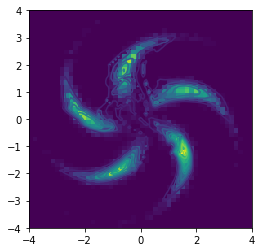

In [7]:
from jax.experimental.optimizers import adam

opt_init, opt_update, get_params = adam(step_size=1e-4)
grad_loss = grad(loss, 0)

@jit
def step(i, opt_state, batch):
    params = get_params(opt_state)
    g = grad_loss(params, batch)
    return opt_update(i, g, opt_state)

iters = 2500
data_generator = (x[true_np.random.choice(x.shape[0], 512)] for _ in range(iters))
opt_state = opt_init(nf_params)

for i in range(iters):
    opt_state = step(i, opt_state, next(data_generator))
    
    # Show progress
    if i % 25 == 0:
        clear_output(wait=True)
        
        fig = plt.figure(figsize=(4, 4))
        #plt.title("iteration = {}, loss = {}".format(i, loss(get_params(opt_state), x)))
        
        plt.hist2d(x[:, 0], x[:, 1], bins=50, range=[(-4, 4), (-4, 4)], density=True)
        plt.xlim(-4, 4)
        plt.ylim(-4, 4)    
    
        _x = np.arange(-4.0, 4.0, 0.1)
        _y = np.arange(-4.0, 4.0, 0.1)
        X, Y = np.meshgrid(_x, _y)
        shape = X.shape
        batch = np.hstack([X.reshape(-1, 1), Y.reshape(-1, 1)])
        z, jacobians = nf_forward(batch, nf_nn, get_params(opt_state), return_jacobians=True)
        Z = np.exp(multivariate_normal.logpdf(z, mean=np.zeros(D), cov=np.eye(D)) + \
                   sum([np.log(np.abs(vdet(J))) for J in jacobians]))
        Z = Z.reshape(shape)
        CS = plt.contour(X, Y, Z, levels=10)
        
        plt.show()

# Sampling

Normalizing flows are not only good for density estimation, they can also be used to generate new samples:

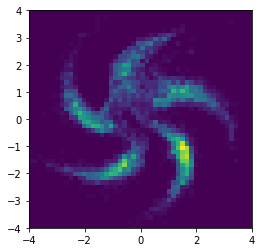

In [9]:
nf_params = get_params(opt_state)

z = random.normal(rng, (10000, 2))
x_fake = nf_backward(z, nf_nn, nf_params)

plt.figure(figsize=(4, 4))
plt.hist2d(x_fake[:, 0], x_fake[:, 1], bins=50, range=[(-4, 4), (-4, 4)], density=True)
plt.xlim(-4, 4)
plt.ylim(-4, 4)    
plt.show()

Overall, results are not bad, but also quite far for from being perfect. Stay tuned for Part 3, in which we will re-implement a better normalizing flow!